# Logistic regression

## Introduction 

Pour ce projet, nous allons utiliser le jeu de données de test présent dans sklearn.datasets nommée `breast_cancer`.
Bien que le nombre d'echantillons ( seulement 569) n'est pas suffisant pour appliquer dans le monde réel un algorithme d'apprentissage des données, cela convient cependant pour illustrer  le concept. 


## Objectif : 
- Construire un modèle de regression logistique.
- Faire une prediction.

## Import packages

In [2]:
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt

## Chargement des données

In [4]:
# On utilise return_X_y pour recuperer séparément les features (X), et la variable à prédire (y)
X,y = datasets.load_breast_cancer(return_X_y=True,as_frame=True)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
X.shape

(569, 30)

Il y a 30 features pour ce jeu de données.

In [ ]:
X[:5]

* y = 1 si la personne est atteinte d'un cancer.
* y = 0 si elle ne l'ai pas.

In [8]:
y.describe()

count    569.000000
mean       0.627417
std        0.483918
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

Dans le jeu de données, plus de la moitié sont des données de personnes atteintes d'un cancer du sein.

In [18]:
X['mean symmetry']

0      0.2419
1      0.1812
2      0.2069
3      0.2597
4      0.1809
        ...  
564    0.1726
565    0.1752
566    0.1590
567    0.2397
568    0.1587
Name: mean symmetry, Length: 569, dtype: float64

In [ ]:
def scatter_plot(df, field1, field2, y, title):
    fig, ax = plt.subplots()
    for color in ['tab:blue', 'tab:orange']:
        n = 750
        mask = y == 1 if color == 'tab:blue' else y == 0
        label = 'Positif' if color == 'tab:blue' else 'Négatif'
        tmp_x = df[mask]
        tmp_y = y[mask]
        
        ax.scatter(tmp_x[field1].values, tmp_x[field2].values, c=color, label=label,
                alpha=0.3, edgecolors='none')

    ax.legend(title="Breast Cancer")
    ax.grid(True)
    ax.set(title=title)

    plt.show()
    
    

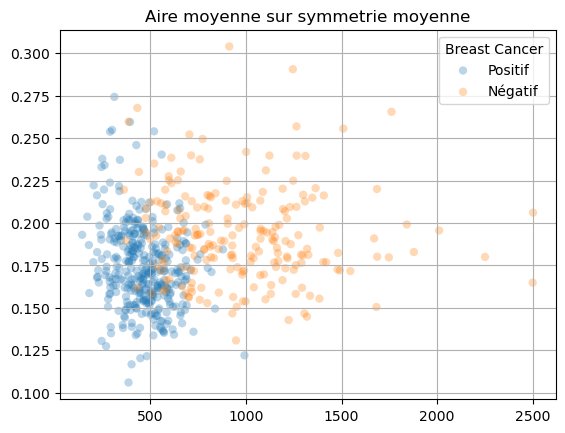

In [38]:
fig, ax = plt.subplots()
for color in ['tab:blue', 'tab:orange']:
    n = 750
    mask = y == 1 if color == 'tab:blue' else y == 0
    label = 'Positif' if color == 'tab:blue' else 'Négatif'
    tmp_x = X[mask]
    tmp_y = y[mask]
    
    ax.scatter(tmp_x['mean area'].values, tmp_x['mean symmetry'].values, c=color, label=label,
               alpha=0.3, edgecolors='none')

ax.legend(title="Breast Cancer")
ax.grid(True)
ax.set(title="surface moyenne sur symmetrie moyenne")

plt.show()

scatter_plot(X, 'mean_area', 'mean_symmetry', y, "surface moyenne sur symmetrie moyenne")
